In [1]:
import numpy as np
import pandas as pd

### Data Preprcessing

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

### Create Features Dataframes

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 7000
days = 10

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,Close
0,249.86,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498
1,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498
2,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729
3,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745
4,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498


### Calculate squared daily deviation 

In [5]:
#Calculate squared daily deviation
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
dv = np.sqrt((dv ** 2).mean())
dv

dv    7.558524
dtype: float64

### Split train/test set

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

### Create cross validation folds

In [7]:
def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 

### Define metrics and print metrics

In [8]:
# Import metrics, Crete custom metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    print('RMSE %f'%  rmse(test, pred))
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')

In [9]:
n_splits = 7
size =1000

cv_sets = create_cv_sets(n_splits, size)

### Train and Tune Linear Regressor

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

def get_lr_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Iterate through cross validation sets, calc errors, print metrics

In [11]:
#Iterate through cv_sets, calc errors, print metrics
lr_regs = []
lr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    lr_reg = get_lr_model(X_train, y_train)
    lr_regs.append(lr_reg)
    pred = lr_reg.predict(X_test)
    lr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)

RMSE 4.828894
Root Mean Squared Percentage Error 1.082763
Mean Absolute Error: 3.709067
Explained Variance Score: 0.974417
Mean Squared Error: 23.318220
R2 score: 0.974371

RMSE 4.842967
Root Mean Squared Percentage Error 1.085132
Mean Absolute Error: 3.732799
Explained Variance Score: 0.974816
Mean Squared Error: 23.454328
R2 score: 0.974760

RMSE 4.796163
Root Mean Squared Percentage Error 1.072344
Mean Absolute Error: 3.700744
Explained Variance Score: 0.975834
Mean Squared Error: 23.003181
R2 score: 0.975730

RMSE 4.785782
Root Mean Squared Percentage Error 1.068607
Mean Absolute Error: 3.691811
Explained Variance Score: 0.976295
Mean Squared Error: 22.903712
R2 score: 0.976170

RMSE 4.792780
Root Mean Squared Percentage Error 1.068653
Mean Absolute Error: 3.698223
Explained Variance Score: 0.976387
Mean Squared Error: 22.970741
R2 score: 0.976264

RMSE 4.757853
Root Mean Squared Percentage Error 1.059355
Mean Absolute Error: 3.663104
Explained Variance Score: 0.976941
Mean Squared

In [12]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

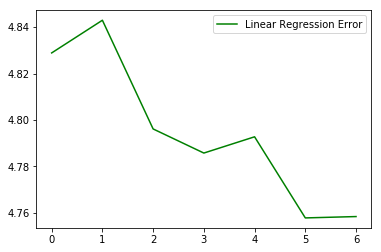

In [13]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.legend()
plt.show()

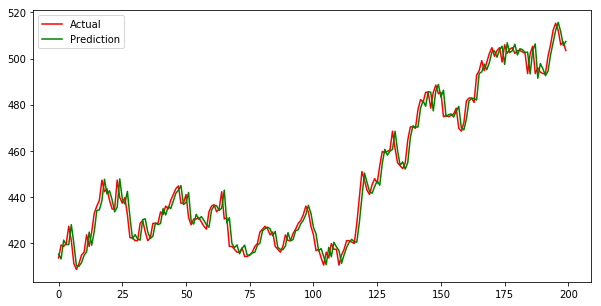

In [14]:
rcParams['figure.figsize'] = 10,5
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, lr_regs[n_splits - 1].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [15]:
lr_regs[6].coef_

array([[-0.00304643,  0.02585659,  0.03217198, -0.01292438,  0.0185251 ,
        -0.13727681,  0.1780228 , -0.06227845, -0.09536674,  1.05693576]])

In [16]:
from sklearn.linear_model import Ridge 

def get_ridge_model(X_train, X_test, y_train, y_test):
    r_reg = Ridge()
    r_reg.fit(X_train, y_train)
    return r_reg

In [17]:
#Iterate through cv_sets, calc errors, print metrics
rr_regs=[]
rr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    rr_reg = get_ridge_model(X_train,X_test,y_train,y_test)
    pred = rr_reg.predict(X_test)
    rr_regs.append(rr_reg)
    rr_errs.append(rmse(y_test, pred))
    print_metrics(y_test, pred)    

RMSE 4.869521
Root Mean Squared Percentage Error 1.089557
Mean Absolute Error: 3.762083
Explained Variance Score: 0.974412
Mean Squared Error: 23.712231
R2 score: 0.973938

RMSE 4.890978
Root Mean Squared Percentage Error 1.093220
Mean Absolute Error: 3.795264
Explained Variance Score: 0.974795
Mean Squared Error: 23.921670
R2 score: 0.974257

RMSE 4.858452
Root Mean Squared Percentage Error 1.083374
Mean Absolute Error: 3.776117
Explained Variance Score: 0.975816
Mean Squared Error: 23.604551
R2 score: 0.975095

RMSE 4.848795
Root Mean Squared Percentage Error 1.080062
Mean Absolute Error: 3.765104
Explained Variance Score: 0.976303
Mean Squared Error: 23.510815
R2 score: 0.975538

RMSE 4.859070
Root Mean Squared Percentage Error 1.080956
Mean Absolute Error: 3.775815
Explained Variance Score: 0.976423
Mean Squared Error: 23.610558
R2 score: 0.975603

RMSE 4.818871
Root Mean Squared Percentage Error 1.070383
Mean Absolute Error: 3.738977
Explained Variance Score: 0.976954
Mean Squared

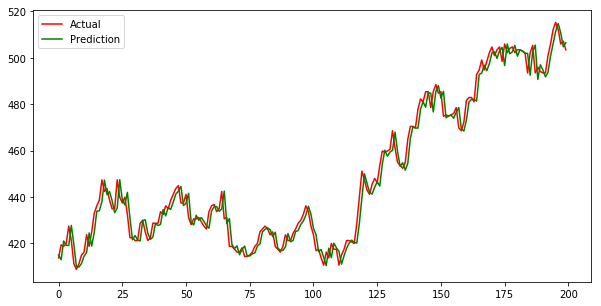

In [18]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, rr_regs[6].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

In [19]:
rr_regs[1].coef_

array([[ 0.00425511,  0.02326752,  0.02887893, -0.0211307 ,  0.01547421,
        -0.13709511,  0.17784227, -0.05709013, -0.08828309,  1.0498419 ]])

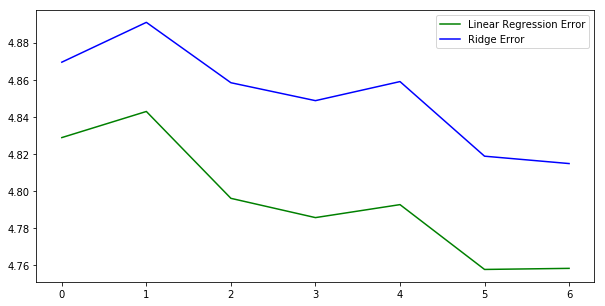

In [20]:
t = range(n_splits)
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.legend()
plt.show()

In [21]:
from sklearn.svm import LinearSVR
def lsvr(X_train, X_test, y_train, y_test):
    svr = LinearSVR()
    svr.fit(X_train, y_train.values.ravel())
    return svr

In [22]:
#Iterate through cv_sets, calc errors, print metrics
svrs=[]
svr_errs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svr = lsvr(X_train, X_test, y_train, y_test)
    svrs.append(svr)
    pred = svr.predict(X_test)
    svr_errs.append(rmse(y_test.values.ravel(), pred)) 
    print_metrics(y_test.values.ravel(), pred)


RMSE 6.048436
Root Mean Squared Percentage Error 1.368141
Mean Absolute Error: 4.852262
Explained Variance Score: 0.974423
Mean Squared Error: 36.583580
R2 score: 0.959791

RMSE 11.651227
Root Mean Squared Percentage Error 2.625505
Mean Absolute Error: 10.604313
Explained Variance Score: 0.974393
Mean Squared Error: 135.751102
R2 score: 0.853915

RMSE 9.656235
Root Mean Squared Percentage Error 2.138593
Mean Absolute Error: 8.611246
Explained Variance Score: 0.975561
Mean Squared Error: 93.242884
R2 score: 0.901620

RMSE 5.335720
Root Mean Squared Percentage Error 1.200390
Mean Absolute Error: 4.164126
Explained Variance Score: 0.976237
Mean Squared Error: 28.469907
R2 score: 0.970378

RMSE 6.408638
Root Mean Squared Percentage Error 1.418380
Mean Absolute Error: 5.350957
Explained Variance Score: 0.976453
Mean Squared Error: 41.070637
R2 score: 0.957561

RMSE 6.927674
Root Mean Squared Percentage Error 1.529714
Mean Absolute Error: 5.900624
Explained Variance Score: 0.976945
Mean Squa

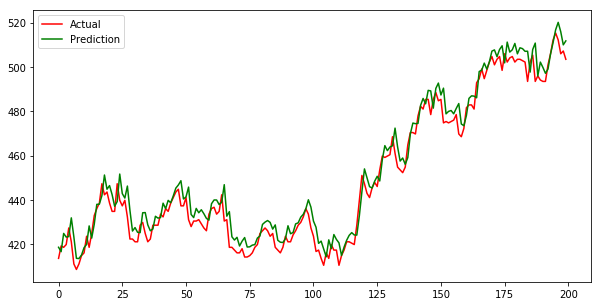

In [23]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.legend()
plt.show()

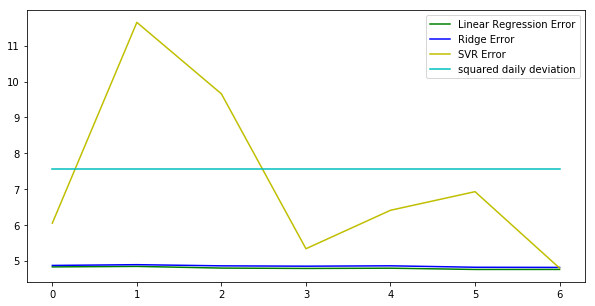

In [24]:
rcParams['figure.figsize'] = 10,5
dvl = [dv]* n_splits
t = range(n_splits)
plt.yticks(np.arange(0, max(svr_errs)))
plt.plot(t, lr_errs, 'g', label='Linear Regression Error')
plt.plot(t, rr_errs, 'b', label='Ridge Error')
plt.plot(t, svr_errs, 'y', label='SVR Error')
plt.plot(t, dvl, 'c', label='squared daily deviation')
plt.legend()
plt.show()

In [25]:
last = np.array([310.5,312.5, 313.5,316.200012,316.299988,314.799988,316.100006,320.5,308.79998,308.700012]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred

array([[308.88484237]])

In [26]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00]).reshape(1,-1)
pred = lr_regs[0].predict(last)
pred


array([[325.34466854]])

In [28]:
from sklearn.externals import joblib
joblib.dump(lr_regs[0], 'prediction_model_full.pkl') 

['prediction_model_full.pkl']